# Network Analysis

In [6]:
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
from itertools import combinations

In [52]:
data_path = "data/"
output_path = "graphs/"

In [8]:
decades = list(range(1840, 2000, 10))
mentions_fr = pd.read_pickle(data_path + "mentions_fr.pkl")
mentions_de = pd.read_pickle(data_path + 'mentions_de.pkl')
mentions_all = pd.concat([mentions_fr, mentions_de])

In [9]:
mentions_all.head()

,entity,surface,qid,lSentenceOffset,rSentenceOffset,sentence_idx:,lArticleOffset,rArticleOffset,id,article,newspaper,date,year,decade,agency,language,country
0,org.ent.pressagency.Havas,Havas,Q2826560,30,35,1,84,89,LLE-1939-11-27-a-i0076:1:30:35:84:89:newsag:be...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,Havas,fr,CH
1,org.ent.pressagency.UP-UPI,United Press,Q493845,2,14,7,595,607,LLE-1939-11-27-a-i0076:7:2:14:595:607:newsag:b...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,UP-UPI,fr,CH
2,org.ent.pressagency.UP-UPI,United Press,Q493845,0,12,10,1364,1376,LLE-1939-11-27-a-i0076:10:0:12:1364:1376:newsa...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,UP-UPI,fr,CH
3,org.ent.pressagency.UP-UPI,United Press,Q493845,2,14,16,2181,2193,LLE-1939-11-27-a-i0076:16:2:14:2181:2193:newsa...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,UP-UPI,fr,CH
4,org.ent.pressagency.UP-UPI,Press,Q493845,48,53,18,2531,2536,LLE-1939-11-27-a-i0076:18:48:53:2531:2536:news...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,UP-UPI,fr,CH


## Create Multigraph

In [34]:
def make_multigraph(df, edge_cols, bipartite=True, node0='newspaper', node1='agency', print_attrs=True):
    #make edge list
    edge_attrs = df[edge_cols].to_dict(orient='records')
    edge_list = list(zip(df[node0], df[node1], edge_attrs))

    #create graph
    G = nx.MultiGraph()
    keys = G.add_edges_from(edge_list)

    if bipartite:
        #set newspaper node attr to 0, agency node attr to 1
        N0 = mentions_all[node0].unique()
        N1 = mentions_all[node1].unique()

        bipartite_attrs = dict(  list(zip( N0, [{"bipartite": 0}] * len(N0) )) +
                        list(zip( N1, [{"bipartite": 1}] * len(N1) ))
                        )
        nx.set_node_attributes(G, bipartite_attrs)

    if print_attrs:
        print(f"Edge list: {edge_list[:5]} ...")
        print(f"Node list: {list(bipartite_attrs.items())[:5]} ...")

    
    return G

In [35]:
G = make_multigraph(mentions_all, edge_cols=['date', 'year', 'decade', 'language'], bipartite=True)

Edge list: [('LLE', 'Havas', {'date': '1939-11-27', 'year': 1939, 'decade': 1930, 'language': 'fr'}), ('LLE', 'UP-UPI', {'date': '1939-11-27', 'year': 1939, 'decade': 1930, 'language': 'fr'}), ('LLE', 'UP-UPI', {'date': '1939-11-27', 'year': 1939, 'decade': 1930, 'language': 'fr'}), ('LLE', 'UP-UPI', {'date': '1939-11-27', 'year': 1939, 'decade': 1930, 'language': 'fr'}), ('LLE', 'UP-UPI', {'date': '1939-11-27', 'year': 1939, 'decade': 1930, 'language': 'fr'})] ...
Node list: [('LLE', {'bipartite': 0}), ('GDL', {'bipartite': 0}), ('IMP', {'bipartite': 0}), ('JDG', {'bipartite': 0}), ('EXP', {'bipartite': 0})] ...


In [36]:
G.nodes.data()

NodeDataView({'LLE': {'bipartite': 0}, 'Havas': {'bipartite': 1}, 'UP-UPI': {'bipartite': 1}, 'Reuters': {'bipartite': 1}, 'GDL': {'bipartite': 0}, 'IMP': {'bipartite': 0}, 'ATS-SDA': {'bipartite': 1}, 'AFP': {'bipartite': 1}, 'JDG': {'bipartite': 0}, 'EXP': {'bipartite': 0}, 'unk': {'bipartite': 1}, 'AP': {'bipartite': 1}, 'LSE': {'bipartite': 0}, 'Wolff': {'bipartite': 1}, 'LCE': {'bipartite': 0}, 'luxembourg1935': {'bipartite': 0}, 'indeplux': {'bipartite': 0}, 'Extel': {'bipartite': 1}, 'GAV': {'bipartite': 0}, 'LCG': {'bipartite': 0}, 'DPA': {'bipartite': 1}, 'LES': {'bipartite': 0}, 'Stefani': {'bipartite': 1}, 'lunion': {'bipartite': 0}, 'DNB': {'bipartite': 1}, 'luxwort': {'bipartite': 0}, 'SDT': {'bipartite': 0}, 'avenirgdl': {'bipartite': 0}, 'LNF': {'bipartite': 0}, 'luxzeit1858': {'bipartite': 0}, 'LTF': {'bipartite': 0}, 'LBP': {'bipartite': 0}, 'LLS': {'bipartite': 0}, 'courriergdl': {'bipartite': 0}, 'LCR': {'bipartite': 0}, 'luxland': {'bipartite': 0}, 'CDV': {'bipartit

## Make Multigraph with Edges grouped by Year

In [37]:
mentions_yearly = mentions_all[['newspaper', 'agency', 'year', 'decade', 'language']].groupby(['newspaper', 'agency', 'year']).agg({
    'language': 'count',
    'decade': 'first'
}).reset_index().rename(columns={'language': 'weight'})
mentions_yearly.head()

,newspaper,agency,year,weight,decade
0,BLB,SPK-SMP,1847,2,1840
1,BLB,unk,1847,1,1840
2,BNN,AFP,1891,1,1890
3,BNN,ATS-SDA,1886,1,1880
4,BNN,ATS-SDA,1887,2,1880


### Threshold

In [38]:
def get_percentage(df, col, value, decimals=0):
    df_selected = df[df[col] == value]
    return round(len(df_selected)/len(df)*100, decimals)

for value in range(1,13):
    print(f"%nodes with weight = {value}: {get_percentage(mentions_yearly, 'weight', value)}%")

%nodes with weight = 1: 26.0%
%nodes with weight = 2: 11.0%
%nodes with weight = 3: 6.0%
%nodes with weight = 4: 4.0%
%nodes with weight = 5: 4.0%
%nodes with weight = 6: 3.0%
%nodes with weight = 7: 2.0%
%nodes with weight = 8: 2.0%
%nodes with weight = 9: 2.0%
%nodes with weight = 10: 1.0%
%nodes with weight = 11: 1.0%
%nodes with weight = 12: 1.0%


In [41]:
#threshold = 5: at least once every two months
mentions_yearly_above5 = mentions_yearly[mentions_yearly['weight'] > 5]

### Make Graphs

In [45]:
print("Graph with all edges")
G_yearly = make_multigraph(mentions_yearly, edge_cols=['year', 'decade', 'weight'], bipartite=True)
print("\nGraph with edges with weight above 5")
G_yearly_above5 = make_multigraph(mentions_yearly_above5, edge_cols=['year', 'decade', 'weight'], bipartite=True)

Graph with all edges
Edge list: [('BLB', 'SPK-SMP', {'year': 1847, 'decade': 1840, 'weight': 2}), ('BLB', 'unk', {'year': 1847, 'decade': 1840, 'weight': 1}), ('BNN', 'AFP', {'year': 1891, 'decade': 1890, 'weight': 1}), ('BNN', 'ATS-SDA', {'year': 1886, 'decade': 1880, 'weight': 1}), ('BNN', 'ATS-SDA', {'year': 1887, 'decade': 1880, 'weight': 2})] ...
Node list: [('LLE', {'bipartite': 0}), ('GDL', {'bipartite': 0}), ('IMP', {'bipartite': 0}), ('JDG', {'bipartite': 0}), ('EXP', {'bipartite': 0})] ...

Graph with edges with weight above 5
Edge list: [('BNN', 'ATS-SDA', {'year': 1888, 'decade': 1880, 'weight': 8}), ('BNN', 'ATS-SDA', {'year': 1890, 'decade': 1890, 'weight': 6}), ('BNN', 'ATS-SDA', {'year': 1891, 'decade': 1890, 'weight': 9}), ('BNN', 'ATS-SDA', {'year': 1892, 'decade': 1890, 'weight': 6}), ('BNN', 'Havas', {'year': 1887, 'decade': 1880, 'weight': 6})] ...
Node list: [('LLE', {'bipartite': 0}), ('GDL', {'bipartite': 0}), ('IMP', {'bipartite': 0}), ('JDG', {'bipartite': 0})

## Make "Subgraphs"

In [46]:
ag_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
np_nodes = set(G) - ag_nodes
ag_nodes

{'BLB',
 'BNN',
 'CDV',
 'CON',
 'DFS',
 'DLE',
 'DTT',
 'DVF',
 'EDA',
 'EXP',
 'EZR',
 'FCT',
 'FZG',
 'GAV',
 'GAZ',
 'GDL',
 'HRV',
 'IMP',
 'JDF',
 'JDG',
 'JDV',
 'LAB',
 'LBP',
 'LCE',
 'LCG',
 'LCR',
 'LES',
 'LLE',
 'LLS',
 'LNF',
 'LSE',
 'LTF',
 'LVE',
 'MGS',
 'NTS',
 'NZG',
 'NZZ',
 'OIZ',
 'SDT',
 'SGZ',
 'SMZ',
 'VHT',
 'WHD',
 'ZBT',
 'armeteufel',
 'avenirgdl',
 'buergerbeamten',
 'courriergdl',
 'deletz1893',
 'demitock',
 'diekwochen',
 'dunioun',
 'gazgrdlux',
 'indeplux',
 'landwortbild',
 'lunion',
 'luxembourg1935',
 'luxland',
 'luxwort',
 'luxzeit1844',
 'luxzeit1858',
 'obermosel',
 'onsjongen',
 'schmiede',
 'tageblatt',
 'volkfreu1869',
 'waechtersauer',
 'waeschfra'}

In [47]:
def retrieve_freq(row, col_keep, node):
    #lookup dictionary in row[col_keep]
    return row[col_keep][row[node]]


def create_subgraph_edgelist(df, col_keep = 'agency', col_drop = 'newspaper', time_granularity = 'year'):
    #count occurrence of agency mentions per year and newspaper
    df_grouped = df.groupby([col_drop, time_granularity]).agg({col_keep: Counter}).reset_index()
    #get all possible combinations of agency tuples per year and newspaper
    df_grouped['comb'] = df_grouped[col_keep].apply(lambda x: list(combinations(x.keys(),2)))
    #explode list of tuples to one tuple per row
    df_grouped = df_grouped.explode('comb').dropna()
    df_grouped['node1'] = df_grouped['comb'].apply(lambda x: x[0])
    df_grouped['node2'] = df_grouped['comb'].apply(lambda x: x[1])
    df_grouped = df_grouped.drop(columns='comb')
    #keep frequency of agency mentions per year and newspaper
    df_grouped['freq_node1'] = df_grouped.apply(lambda x: retrieve_freq(x, col_keep, 'node1'), axis=1)
    df_grouped['freq_node2'] = df_grouped.apply(lambda x: retrieve_freq(x, col_keep, 'node2'), axis=1)

    #create edgelist
    edge_attrs = df_grouped[[time_granularity, 'freq_node1', 'freq_node2']].to_dict(orient='records')
    edge_list = list(zip(df_grouped['node1'], df_grouped['node2'], edge_attrs))

    return edge_list

In [48]:
G_agencies_edges = create_subgraph_edgelist(mentions_all, col_keep='agency', col_drop='newspaper')
print(f"Length of Edgelist: {len(G_agencies_edges)}, first entries: {G_agencies_edges[:10]} ...")
G_agencies = nx.MultiGraph()
_ = G_agencies.add_edges_from(G_agencies_edges)

Length of Edgelist: 48774, first entries: [('unk', 'SPK-SMP', {'year': 1847, 'freq_node1': 1, 'freq_node2': 2}), ('unk', 'Havas', {'year': 1886, 'freq_node1': 13, 'freq_node2': 2}), ('unk', 'ATS-SDA', {'year': 1886, 'freq_node1': 13, 'freq_node2': 1}), ('unk', 'ag', {'year': 1886, 'freq_node1': 13, 'freq_node2': 3}), ('unk', 'DPA', {'year': 1886, 'freq_node1': 13, 'freq_node2': 1}), ('Havas', 'ATS-SDA', {'year': 1886, 'freq_node1': 2, 'freq_node2': 1}), ('Havas', 'ag', {'year': 1886, 'freq_node1': 2, 'freq_node2': 3}), ('Havas', 'DPA', {'year': 1886, 'freq_node1': 2, 'freq_node2': 1}), ('ATS-SDA', 'ag', {'year': 1886, 'freq_node1': 1, 'freq_node2': 3}), ('ATS-SDA', 'DPA', {'year': 1886, 'freq_node1': 1, 'freq_node2': 1})] ...


In [49]:
G_newspapers_edges = create_subgraph_edgelist(mentions_all, col_keep='newspaper', col_drop='agency')
print(f"Length of Edgelist: {len(G_newspapers_edges)}, first entries: {G_newspapers_edges[:10]} ...")
G_newspaper = nx.MultiGraph()
_ = G_newspaper.add_edges_from(G_newspapers_edges)

Length of Edgelist: 55247, first entries: [('JDF', 'JDG', {'year': 1832, 'freq_node1': 1, 'freq_node2': 1}), ('GDL', 'luxwort', {'year': 1852, 'freq_node1': 1, 'freq_node2': 2}), ('GDL', 'LNF', {'year': 1852, 'freq_node1': 1, 'freq_node2': 1}), ('luxwort', 'LNF', {'year': 1852, 'freq_node1': 2, 'freq_node2': 1}), ('luxwort', 'LCG', {'year': 1854, 'freq_node1': 3, 'freq_node2': 1}), ('luxwort', 'JDG', {'year': 1854, 'freq_node1': 3, 'freq_node2': 3}), ('LCG', 'JDG', {'year': 1854, 'freq_node1': 1, 'freq_node2': 3}), ('luxwort', 'LCG', {'year': 1858, 'freq_node1': 1, 'freq_node2': 1}), ('luxwort', 'courriergdl', {'year': 1858, 'freq_node1': 1, 'freq_node2': 1}), ('LCG', 'courriergdl', {'year': 1858, 'freq_node1': 1, 'freq_node2': 1})] ...


## First Exploration

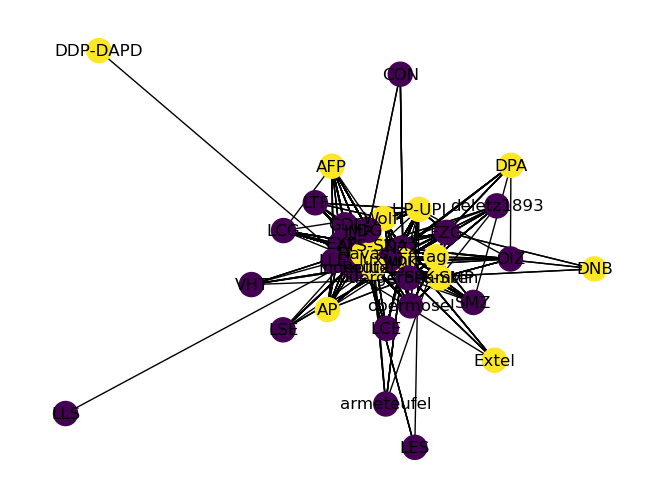

In [50]:
G_1900 = G.edge_subgraph([e[:3] for e in G.edges.data(keys=True) if e[3]["decade"] == 1900])
nx.draw(G_1900, with_labels=True, node_color=[node[1]['bipartite'] for node in G_1900.nodes.data()])

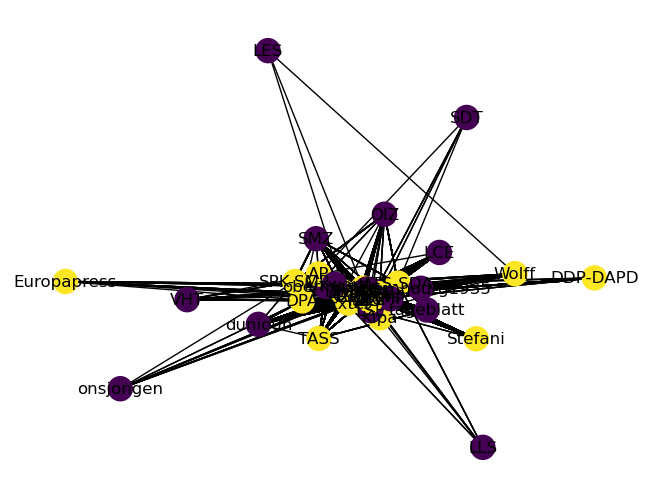

In [51]:
G_1940 = G.edge_subgraph([e[:3] for e in G.edges.data(keys=True) if e[3]["decade"] == 1940])
nx.draw(G_1940, with_labels=True, node_color=list(dict(G_1940.nodes.data("bipartite")).values()))

## Saving Graphs

In [53]:
nx.write_gexf(G, output_path + "G_np_ag.gexf")
nx.write_gexf(G_yearly, output_path + "G_yearly.gexf")
nx.write_gexf(G_yearly_above5, output_path + "G_yearly_above5.gexf")
nx.write_gexf(G_newspaper, output_path + "G_np.gexf")
nx.write_gexf(G_agencies, output_path + "G_ag.gexf")